In [2]:
#@title Everything not mine is copyright 2020 Google LLC. Double-click here for full information.
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
 
# Yann LeCun and Corinna Cortes hold the copyright of MNIST dataset,
# which is a derivative work from original NIST datasets. 
# MNIST dataset is made available under the terms of the 
# Creative Commons Attribution-Share Alike 3.0 license.

This Notebook is heavily modified from the MLCC programming project with single-digit images here:
https://colab.research.google.com/github/google/eng-edu/blob/master/ml/cc/exercises/multi-class_classification_with_MNIST.ipynb

In [39]:
# load some standard utilities.
%tensorflow_version 2.x
#from __future__ import absolute_import, division, print_function, unicode_literals
 
import random as rd
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from matplotlib import pyplot as plt

tf.__version__

'2.3.0'

In [102]:
# data massage
x_train = pd.read_csv('/content/training_set.csv', index_col=0)
#x_train = x_train.reindex(np.random.permutation(list(x_train.index)))

moves = pd.read_csv('/content/moves.csv', index_col=0)
#moves = moves.reindex(x_train.index)

x_test = x_train[950:]
x_train = x_train[:950]

y_train = np.asarray(x_train['labels'])
x_train = x_train.drop(columns=['labels'])

y_test = np.asarray(x_test['labels'])
x_test = x_test.drop(columns=['labels'])

x_train_norm = np.asarray(x_train)/2
x_test_norm = np.asarray(x_test)/2

test_moves = moves[950:]
train_moves = moves[:950]

In [104]:
moves.dtypes

0    int64
1    int64
2    int64
3    int64
4    int64
5    int64
6    int64
dtype: object

In [123]:
def m2p(move = []):
#move = train_moves.iloc[0]
    try: 
        assert len(move) == 7
    except AssertionError:
        print("Need a list of 7 column ratings. Recieved", move)
        return move

    min_rating = int(min(move))
    #max_rating = max(move)
    #print (min_rating)

    if min_rating < 0:
        move = [int(m) - min_rating for m in move]
    sum_ratings = sum(move)  
    if sum_ratings == 0:
        probs = [0,0,0,0,0,0,0]  
    else:
        probs = [round(float(m)/sum_ratings, 5) for m in move]
    #norms = [(m - min_rating) / (max_rating - min_rating) for m in move]
    return probs#, norms
    #print (probs)   

In [124]:
move_probs = []
for i in range(len(train_moves)):
    move_probs += [m2p(train_moves.iloc[i])]
move_probs

## Create a hybrid neural net model

In [141]:
x_train_norm = x_train_norm.reshape(950, 42)
x_test_norm = x_test_norm.reshape(50, 42)

In [142]:
 # SET UP A HYBRID NEURAL NET 
 
def create_mixedNN(learning_rate):
    """Create and compile a convolutional neural net."""  
    # Define the kind of model to use.
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Input(shape=(42)))
    #model.add(tf.keras.layers.Conv2D(1, 1, activation='relu'))
    #model.add(tf.keras.layers.Conv2D(128, 2, padding='same', activation='relu'))
    #model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(units=512, activation='relu'))
    model.add(tf.keras.layers.Dropout(rate=0.4))
    model.add(tf.keras.layers.Dense(units=256, activation='relu'))
    model.add(tf.keras.layers.Dropout(rate=0.3))
    model.add(tf.keras.layers.Dense(units=7, activation='softmax'))     
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=learning_rate),
                    loss="sparse_categorical_crossentropy",
                    metrics=['accuracy']) 
    return model

In [143]:
 # train on the training set with 10% held back for validation #
def train_model(model, train_features, train_label, epochs,
                batch_size=None, validation_split=None):

    history = model.fit(x=train_features, y=train_label, 
                        batch_size=batch_size,
                        epochs=epochs, shuffle=True, 
                        validation_split=validation_split)

    # Gather the model's metrics after each round of training
    epochs = history.epoch
    hist = pd.DataFrame(history.history)
    return epochs, hist

In [149]:
# The adjustable "hyperparameters" for the model
learning_rate = 0.001
epochs = 30
batch_size = 50
validation_split = None

In [ ]:
mixed_NN = create_mixedNN(learning_rate)
mixed_NN.summary()

In [ ]:
# Train and evalate mixed NN

#mixed_NN = create_mixedNN(learning_rate)
 
# TRAIN:
mixed_epochs, mixed_hist = train_model(mixed_NN, x_train_norm, y_train, 
                                        epochs, batch_size, validation_split)

# EVALUATE AGAINST THE TEST SET:
print("\n Evaluate the new model against the test set:")
mixed_NN.evaluate(x=x_test_norm,y=y_test, batch_size=batch_size)

In [ ]:
mixed_NN.evaluate(x=x_test_norm,y=y_test, batch_size=batch_size)

In [40]:
def getResults():  
    results = pd.DataFrame(columns=['Answer','Guess','P(G)'])#,'P(A)'])  
    results['Answer'] = y_train
    predicts = mixed_NN.predict(x_train_norm).round(5)
    for j in range(len(x_train_norm)):
        probs = predicts[j] # one row of 7 probabilities 
        maxr = max(probs)   # top probability
        for i in range(0,7):
            if probs[i] == maxr:
                results.at[j,'Guess'] = i
                results.at[j,'P(G)'] = maxr*100
    return results

In [153]:
predicts = mixed_NN.predict(x_train_norm).round(5)
predicts

array([[0.1598 , 0.02994, 0.06336, ..., 0.02919, 0.25383, 0.05709],
       [0.02044, 0.52331, 0.05929, ..., 0.07498, 0.10932, 0.15381],
       [0.07418, 0.27759, 0.46735, ..., 0.09667, 0.06071, 0.0066 ],
       ...,
       [0.10877, 0.26635, 0.41103, ..., 0.00517, 0.09772, 0.03608],
       [0.57232, 0.14209, 0.02145, ..., 0.01621, 0.00992, 0.23721],
       [0.0098 , 0.0225 , 0.03198, ..., 0.00708, 0.06406, 0.86443]],
      dtype=float32)

In [158]:
move_probs# = np.array(move_probs)


array([[0.10417, 0.10417, 0.20833, ..., 0.16667, 0.125  , 0.0625 ],
       [0.     , 0.21053, 0.21053, ..., 0.21053, 0.21053, 0.     ],
       [0.     , 0.     , 1.     , ..., 0.     , 0.     , 0.     ],
       ...,
       [0.09677, 0.09677, 0.29032, ..., 0.     , 0.12903, 0.29032],
       [0.16906, 0.16906, 0.15468, ..., 0.16906, 0.16906, 0.16906],
       [0.16667, 0.1633 , 0.16667, ..., 0.16667, 0.16667, 0.17003]])

##Visualizations

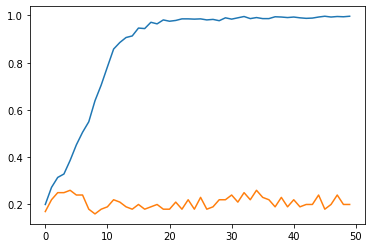

In [42]:
# Plot a graph of the 'accuracy' metric vs. epochs:
plt.plot(range(epochs),mixed_hist["accuracy"])
plt.plot(range(epochs),mixed_hist["val_accuracy"])